In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,StandardScaler
import itertools
from sklearn.metrics import confusion_matrix
import seaborn as sns
np.set_printoptions(precision=4, suppress= True)


In [3]:
df= pd.read_csv("Data.csv")

In [4]:
df=df.drop('Custmer_Id', axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Gender                381109 non-null  object
 1   Age                   381109 non-null  int64 
 2   DL                    381109 non-null  int64 
 3   City_Code             381109 non-null  int64 
 4   Insured               381109 non-null  int64 
 5   Vehicle_Age           381109 non-null  object
 6   Vehicle_Damage        381109 non-null  object
 7   Annual_Premium        381109 non-null  int64 
 8   Sales_Channel         381109 non-null  int64 
 9   Customer_Association  381109 non-null  int64 
 10  Response              381109 non-null  int64 
dtypes: int64(8), object(3)
memory usage: 32.0+ MB


In [6]:
le = LabelEncoder()
df['Response']=df['Response']
df['Gender']=le.fit_transform(df['Gender'])
df['Insured']=le.fit_transform(df['Insured'])
df['DL']=le.fit_transform(df['DL'])
df['City_Code']=le.fit_transform(df['City_Code'])
df['Vehicle_Age']=le.fit_transform(df['Vehicle_Age'])
df['Vehicle_Damage']=le.fit_transform(df['Vehicle_Damage'])
df['Sales_Channel']=le.fit_transform(df['Sales_Channel'])
df['Customer_Association']=le.fit_transform(df['Customer_Association'])


In [58]:
df

,Gender,Age,DL,City_Code,Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Sales_Channel,Customer_Association,Response
0,1,44,1,28,0,2,1,40454,24,207,1
1,1,76,1,3,0,0,0,33536,24,173,0
2,1,47,1,28,0,2,1,38294,24,17,1
3,1,21,1,11,1,1,0,28619,145,193,0
4,0,29,1,41,1,1,0,27496,145,29,0
...,...,...,...,...,...,...,...,...,...,...,...
381104,1,74,1,26,1,0,0,30170,24,78,0
381105,1,30,1,37,1,1,0,40016,145,121,0
381106,1,21,1,30,1,1,0,35118,153,151,0
381107,0,68,1,14,0,2,1,44617,119,64,0


In [10]:
# Upsampling the Data using Smotetomek and increasing the minority class by 50%
from sklearn.model_selection import train_test_split
X = df.drop('Response', axis=1)
y = pd.DataFrame(df['Response'])
y = le.fit_transform(y) 

from imblearn.combine import SMOTETomek
#from imblearn.under_sampling import NearMiss
from collections import Counter
os_us = SMOTETomek(sampling_strategy=0.5)
X_res, y_res = os_us.fit_sample(X, y)
X_res.shape,y_res.shape

((480476, 10), (480476,))

In [11]:
x_train,x_test,y_train,y_test=train_test_split(X_res,y_res,test_size=0.3,random_state=5)

In [13]:
from sklearn.ensemble import RandomForestClassifier
new_model=RandomForestClassifier(n_estimators=500, criterion= 'entropy', random_state=0,oob_score=False,
                                 max_depth=20,min_samples_split=4,min_samples_leaf=2, bootstrap=False)
new_model.fit(x_train,y_train)
pred=new_model.predict(x_test)
#print(classification_report(y_test,pred))

In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
acs=accuracy_score(y_test,pred) 
rs=recall_score(y_test,pred, average='macro') 
ps=precision_score(y_test,pred, average='macro')
print("accuracy score : ",acs)
print("precision score : ",rs)
print("recall score : ",ps)

accuracy score :  0.8600880341694404
precision score :  0.8289913803504316
recall score :  0.8430152551975272


In [13]:
print(pred)

[0 0 0 ... 1 0 0]


     pred_neg  pred_pos
neg     83813     13513
pos      9701     37116


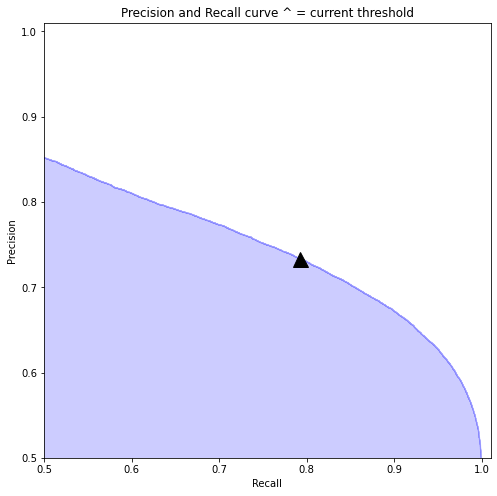

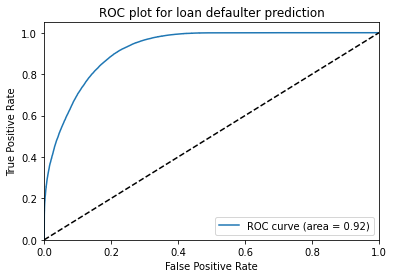

In [14]:
from sklearn.metrics import precision_recall_curve
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)
    
y_scores =new_model.predict_proba(x_test)[:, 1]

p, r, thresholds = precision_recall_curve(y_test, y_scores)

precision_recall_threshold(p, r, thresholds, 0.5)
from sklearn.metrics import roc_curve, auc
def plot_roc(y_test, y_score):
    p,r, thresholds = roc_curve(y_test, y_scores)
  

    plt.figure()
    plt.plot(p, r, label='ROC curve (area = %0.2f)' % auc(p, r))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC plot for loan defaulter prediction")
    plt.legend(loc="lower right")
    plt.show()
#Plot ROC
plot_roc(y_test, y_scores)

In [17]:
y_scores

array([0.5858, 0.0027, 0.0001, ..., 0.    , 0.9494, 0.4467])

In [21]:
pred

array([1, 0, 0, ..., 0, 1, 0], dtype=int64)

In [63]:
x_test = x_test.reset_index(drop = True)


,Gender,Age,DL,City_Code,Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Sales_Channel,Customer_Association,Response_prediction,Probablity
0,1,38,1,41,0,0,1,37785,119,181,NaN,NaN
1,1,65,1,46,0,0,0,31699,24,12,NaN,NaN
2,0,21,1,46,1,1,1,29588,153,227,NaN,NaN
3,0,24,1,8,0,1,0,26981,145,203,0.0,0.000070
4,0,41,1,8,0,0,0,2630,24,174,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
144138,1,53,1,47,0,0,1,19502,119,98,NaN,NaN
144139,0,23,1,23,1,1,0,2630,145,226,0.0,0.091965
144140,1,22,1,25,1,1,0,19377,153,119,NaN,NaN
144141,1,42,1,28,0,1,1,54726,24,237,NaN,NaN


In [74]:
Premium =x_test["Annual_Premium"]

In [77]:
Premium_annual = Premium.to_frame()

In [78]:
Premium_annual

,Annual_Premium
0,37785
1,31699
2,29588
3,26981
4,2630
...,...
144138,19502
144139,2630
144140,19377
144141,54726


In [160]:
df_1.columns = ["Probability"]

In [161]:
df_1

,Probability
0,0.585814
1,0.002666
2,0.000089
3,0.102343
4,0.090119
...,...
144138,0.394711
144139,0.000003
144140,0.000012
144141,0.949385


In [162]:
df_2.columns = ["Predicted_response"]
df_2

,Predicted_response
0,1
1,0
2,0
3,0
4,0
...,...
144138,0
144139,0
144140,0
144141,1


In [163]:
df__t = pd.concat([df_1, df_2], axis =1)

In [166]:
df__t

,Probability,Predicted_response
0,0.585814,1
1,0.002666,0
2,0.000089,0
3,0.102343,0
4,0.090119,0
...,...,...
144138,0.394711,0
144139,0.000003,0
144140,0.000012,0
144141,0.949385,1


In [167]:
df_final = pd.concat([Premium_annual.reset_index(drop = True),df__t], axis =1)

In [168]:
df_final

,Annual_Premium,Probability,Predicted_response
0,37785,0.585814,1
1,31699,0.002666,0
2,29588,0.000089,0
3,26981,0.102343,0
4,2630,0.090119,0
...,...,...,...
144138,19502,0.394711,0
144139,2630,0.000003,0
144140,19377,0.000012,0
144141,54726,0.949385,1


In [171]:
df_final["Predicted_Premium"] = df_final["Annual_Premium"]*df_final["Probability"]

In [172]:
df_final

,Annual_Premium,Probability,Predicted_response,Predicted_Premium
0,37785,0.585814,1,22134.983387
1,31699,0.002666,0,84.509137
2,29588,0.000089,0,2.645465
3,26981,0.102343,0,2761.321010
4,2630,0.090119,0,237.013017
...,...,...,...,...
144138,19502,0.394711,0,7697.653464
144139,2630,0.000003,0,0.008029
144140,19377,0.000012,0,0.227983
144141,54726,0.949385,1,51956.026529


In [173]:
df_final.to_excel("Final_dataset.xlsx")